In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pywt

In [24]:
%matplotlib inline

# Image Compression

Image compression is used to efficently store and/or transmit images. Practically every image you have ever seen has been compressed in some form. You probably use some form of image compression daily, whether it's buffering videos on Youtube or scrolling through your Instagram feed. With the concepts you have learned in this class, you can get a first hand experience into how some of these images are actually compressed.

Firstly, there are two types of compression: lossless and lossy. Lossless compression is when you compress your data without losing any information. This form of compression is found in the Lempel-Ziv based zip functionality built into your computer, or in the Huffman Encoding you may have seen in your other classes (EE126, CS170). These methods are common where loss of information can have catastrophic effects - missing bytes in a file could prevent you from opening that file.

Then there's lossy compression, when you compress data by **intelligently** getting rid of some information. Lossy compression is common in applications where speed and size are more important than quality. Would you rather wait for hours and rack up a large internet bill trying to watch Netflix in perfect quality? Or would you like fast streaming with minimal bandwidth usage that results in slightly blocky images? Most would choose the latter.

This question will focus on three different methods of lossy compression: SVD compression, Fourier Compression, and Wavelet compression.

The question when it comes to lossy compression is how do we choose what information to throw away? The best answer(s) to this question come from when we can find an alternative representation of the image that has some form of sparsity. Why? Because if there is a sparse representation of the image, we can set the near zero coeffecients to zero (so we have less data representing the image) without sacrificing the quality of the image by too much.

## Image Loading

The cell below is necessary for reading in the image we will use for the rest of this notebook. We have provided you two images (the same ones from last week) to run this notebook with. You can submit the notebook with the cells run for either image. (Optional) We highly recommend using your own images to see how the different compression methods might work on different images.

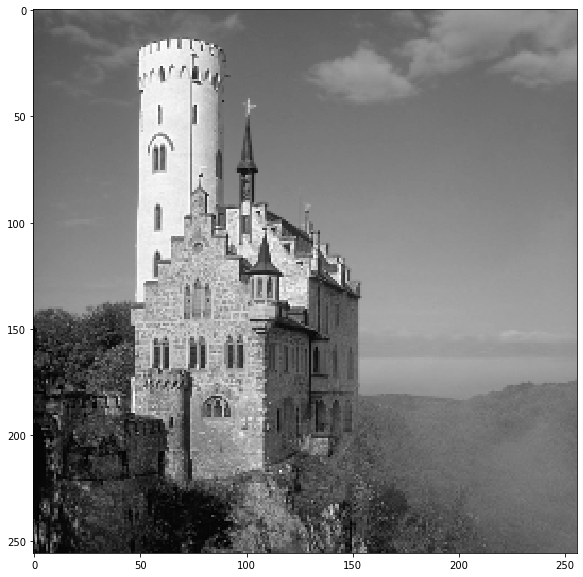

In [25]:
im_name = "lichtenstein.png"
# im_name = "lenna.png"

im = np.mean(plt.imread(im_name),axis=2).astype("float64")
im = (im/im.max())[::2,::2]

plt.figure(figsize=(10,10))
plt.imshow(im, cmap="gray")
plt.show()
assert im.shape == (256,256)

## SVD Image Compression

Because we interpret our image as a matrix, our image has a certain rank. The idea behind image compression with SVD is to represent our compressed image by using a low rank approximation of our original image. But how is the SVD sparse? How do we know whether its a good method for compression? Let's plot the singular values of our image below.

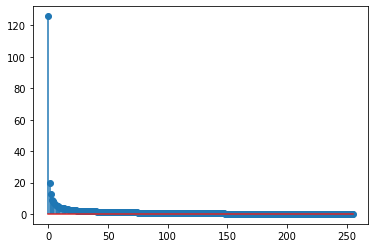

In [26]:
_, s, _ = np.linalg.svd(im)
plt.figure()
plt.stem(s, use_line_collection=True)
plt.show()

As you can see, the sparsity of the SVD refers to the sparsity of the singular values. That means we can use a low rank approximation of the image to represent our original image with fairly high accuracy. Implement the low rank approximation function labeled `svd_comp` below.

#### Quality Measurements

To measure the quality of each compression technique, we will use two quantitative measurements: mean squared error (MSE) and peak signal to noise ratio (PSNR). These metrics are common ones in the imaging field and have been implemented for you. If you would like to learn more about these measurements, you can check [this link](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node18.html).

In [27]:
def mse(gt, im):
    return np.mean(np.square(np.abs(gt-im)))

def psnr(gt, im):
    return 20*np.log10(im.max())-10*np.log10(mse(gt,im))

def svd_comp(im, k):
    assert k <= np.linalg.matrix_rank(im)
    
    u, s, v = np.linalg.svd(im)
    comp_im = u[:,:k]@np.diag(s[0:k])@v[:k,:] # rank k approximation
    
    assert k == np.linalg.matrix_rank(comp_im)
    return comp_im

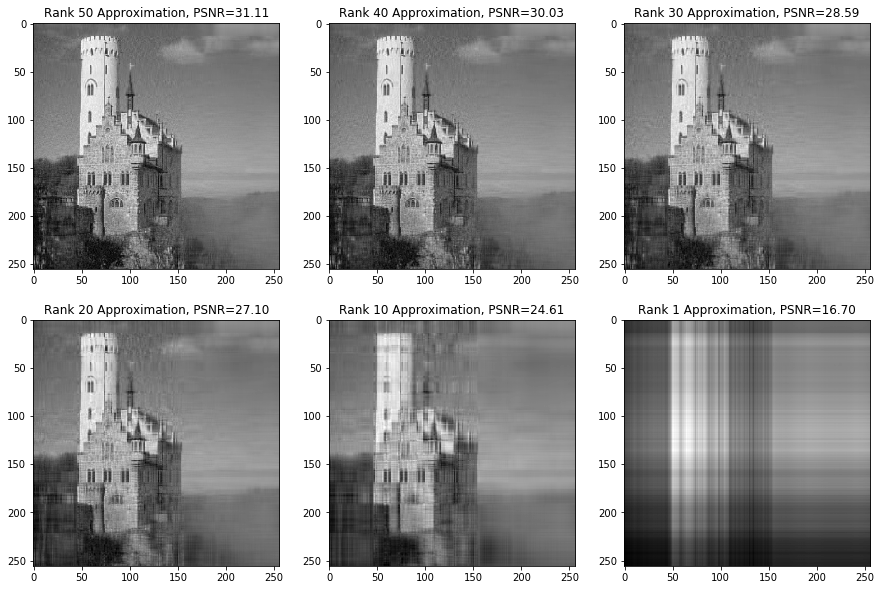

In [28]:
k_vals = np.linspace(1, 50, 6).astype(int)[::-1]
plt.figure(figsize=(15,10))
for i,k in enumerate(k_vals):
    plt.subplot(2, 3, i+1)
    comp_im = svd_comp(im,k)
    plt.imshow(comp_im, cmap='gray')
    plt.title("Rank {} Approximation, PSNR={:.2f}".format(k, psnr(im,comp_im)))

**Q: Describe how the image changes (with respect to the PSNR and overall quality) as the rank decreases**

<font color="blue">A: </font>

We get more noise in the signal as rank decreases.

## Fourier Transform Image Compression

As you discovered in last week's homework, the Fourier transform for natural images tends to have large low frequency coeffecients and small high frequency coeffecients. We can take advantage of this sparsity for image compression, but how do we decide what coeffecients to zero? We can pose the problem as a LASSO problem and solve.

Implement the three functions `loss_fn`, `regularizer`, and `objective_fn` in the cell below, and in the cell below the next, setup the problem as you described it the written part (b) of this question.

In [61]:
#TODO: Fill in the 3 functions below

def loss_fn(Y_hat, Y):
#     frobenius of Y - Y_hat
#     return cp.sum_squares(Y-Y_hat)
    return cp.norm(Y-Y_hat, 'fro')**2

def regularizer(Y_hat):
#     one norm of Y_hat
    return cp.norm(Y_hat, 1)
#     return np.linalg.norm(Y_hat, 1)

def objective_fn(Y_hat, Y, lambd):
    return loss_fn(Y_hat, Y) + lambd*regularizer(Y_hat)

def fft2c(im):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im), norm="ortho"))

def ifft2c(ksp):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ksp), norm="ortho"))

In [66]:
Y_hat = cp.Variable(shape=im.shape, complex=True)
lambd = cp.Parameter(nonneg=True)

obj = cp.Minimize(objective_fn(Y_hat, fft2c(im), lambd))
problem = cp.Problem(obj) #TODO: Create the problem using the functions your wrote above

lambd_values = np.logspace(-4, 4, 6)
ft_compressed_imgs = []

for v in lambd_values:
    print("Solving with lambda = {:.2E}".format(v))
    lambd.value = v
    problem.solve(verbose=False, solver=cp.SCS, max_iters=100)
    ft_compressed_imgs.append(ifft2c(Y_hat.value).real)
print("Done!")

Solving with lambda = 1.00E-04
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 3.98E-03
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 1.58E-01
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 6.31E+00
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 2.51E+02
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 1.00E+04
WARN: aa_init returned NULL, no acceleration applied.
Done!


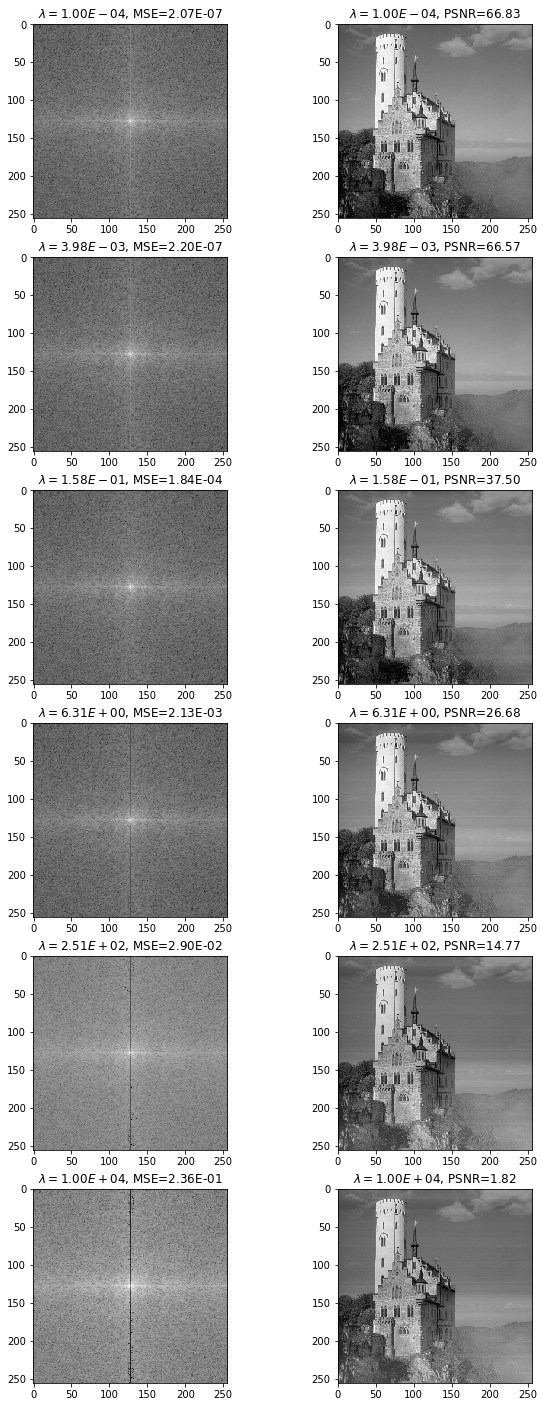

In [67]:
plt.figure(figsize=(10,25))
for i in range(len(lambd_values)):
    plt.subplot(6, 2, 2*i+1)
    ft_im = fft2c(ft_compressed_imgs[i])
    plt.imshow(np.log(np.abs(ft_im)), cmap='gray')
    plt.title("$\lambda={:.2E}$, MSE={:.2E}".format(lambd_values[i], mse(fft2c(im),ft_im)))
    plt.subplot(6, 2, 2*i+2)
    plt.imshow(ft_compressed_imgs[i], cmap='gray')
    plt.title("$\lambda={:.2E}$, PSNR={:.2f}".format(lambd_values[i], psnr(im,ft_compressed_imgs[i])))

**Q: What happens to the MSE, PSNR, and image quality as we increase $\lambda$? Why?**

<font color="blue">A: </font>

We get more noise in the signal as we increase lambda. 

**Q: Qualitatively, how does this method compare to the SVD compression above?**

<font color="blue">A: </font>

We still get a recognizable signal as we experience more noise.

## Wavelet Transform Image Compression

Wavelet transform image compression is very similar to the Fourier transform image compression. In fact, the LASSO problem you used above is the same setup for Wavelet image compression. The only difference now is we are comparing to the wavelet transform of the image instead of the Fourier transform of the image.

Even though the transform itself is out of scope for the class, we wanted to expose you to this form of compression because it is widely used, specifically in in [JPEG-2000](https://en.wikipedia.org/wiki/JPEG_2000).

Fill in the `problem` variable two cells below using the same functions you used above.

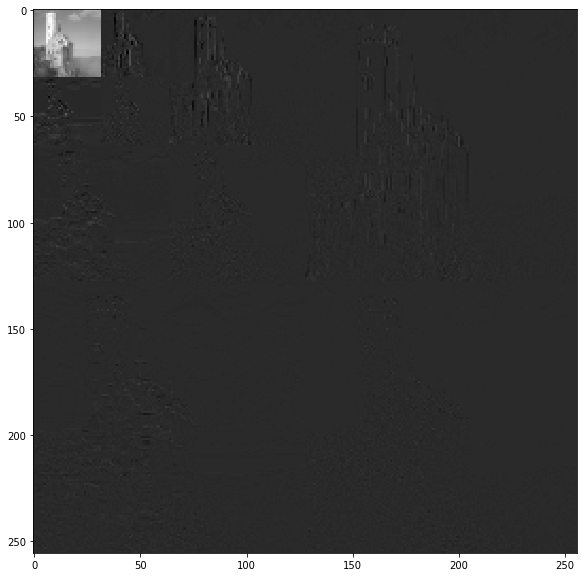

In [68]:
coeffs = pywt.wavedec2(im, "haar", level=3)
wave_im, slices = pywt.coeffs_to_array(coeffs)
plt.figure(figsize=(10,10))
plt.imshow(wave_im, cmap="gray")
plt.show()

In [69]:
Y_hat = cp.Variable(shape=im.shape)
lambd = cp.Parameter(nonneg=True)

obj = cp.Minimize(objective_fn(Y_hat, wave_im, lambd))
problem = cp.Problem(obj) #TODO: Create the problem using the functions your wrote above

lambd_values = np.logspace(-4, 4, 6)
wave_compressed_imgs = []
wave_imgs = []

for v in lambd_values:
    print("Solving with lambda = {:.2E}".format(v))
    lambd.value = v
    problem.solve(verbose=False, solver=cp.SCS, max_iters=100)
    Y_hat.value[:32,:32] = wave_im[:32,:32]
    wave_imgs.append(Y_hat.value)
    wave_compressed_imgs.append(pywt.waverec2(pywt.array_to_coeffs(Y_hat.value, slices, output_format="wavedec2"),"haar"))
print("Done!")

Solving with lambda = 1.00E-04
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 3.98E-03
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 1.58E-01
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 6.31E+00
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 2.51E+02
WARN: aa_init returned NULL, no acceleration applied.
Solving with lambda = 1.00E+04
WARN: aa_init returned NULL, no acceleration applied.
Done!


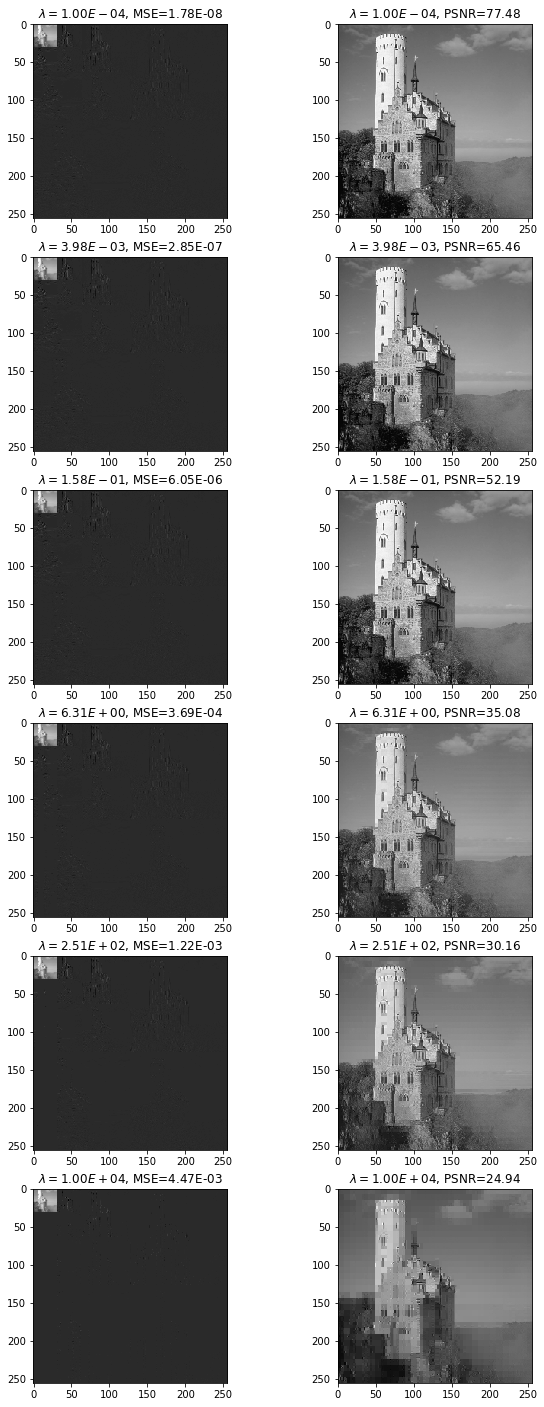

In [70]:
plt.figure(figsize=(10,25))
for i in range(len(lambd_values)):
    plt.subplot(6, 2, 2*i+1) 
    plt.imshow(wave_imgs[i], cmap='gray')
    plt.title("$\lambda={0:.2E}$, MSE={1:0.2E}".format(lambd_values[i],mse(wave_im, wave_imgs[i])))
    plt.subplot(6, 2, 2*i+2) 
    plt.imshow(wave_compressed_imgs[i], cmap='gray')
    plt.title("$\lambda={0:.2E}$, PSNR={1:0.2f}".format(lambd_values[i],psnr(im, wave_compressed_imgs[i])))

**Q: For the same $\lambda$ values, how does the PSNR of the wavelet image compression compare the the fourier image compression?**

<font color="blue">A: </font>

PSNR is higher for wavelet than fourier image compression for the same values of lambda. 

**Q: Qualitatively, which form of image compression do you think looks best? Is your answer a function of $\lambda$?**

<font color="blue">A: </font>

It appears fourier image compression looks best. But note I increased the logspace range from between -4 to 1 to -4 to 4, so I could see a more pronounced difference in quality as lambda increased.